In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data_import = files.upload()

Saving final_song_set.csv to final_song_set.csv


In [ ]:
raw_songs = pd.read_csv('final_song_set.csv').drop(columns= 'Unnamed: 0').rename(columns={"top genre": "genre", "pop": "popularity"})
raw_songs

,Mason_Like,Mary_Like,title,artist,genre,year,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,popularity
0,0,1,Snake Eyes,Feint,dance,2012,1969‑12‑31,174,82,50,-6,26,18,265,0,7,60
1,0,1,Blame,Egypt Central,alternative metal,2011,1969‑12‑31,168,92,40,-5,5,42,199,0,17,25
2,0,1,rap music,Lil Darkie,rap,2020,1969‑12‑31,127,96,58,1,7,72,197,29,36,67
3,0,1,spy?,WHOKILLEDXIX,pop,2020,1969‑12‑31,100,56,87,-5,10,65,154,6,6,75
4,0,1,North Memphis,Pharmacist,aesthetic rap,2019,1969‑12‑31,167,94,72,-6,7,90,136,0,6,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,1,Doubt Me,Ness The Kid,rap,2021,2021‑11‑04,91,65,77,-6,11,49,127,0,8,52
296,1,0,24/7,Liam Tracy,deep underground hip hop,2021,2021‑11‑08,128,67,52,-7,11,41,169,55,24,50
297,0,0,If It Was Easy,PTM,rap,2021,2021‑10‑22,120,64,84,-7,11,59,179,44,5,49
298,0,0,Top for a Pancake,3NIGMA,rap,2019,2021‑10‑05,150,54,90,-9,11,14,131,1,33,43


## Exploratory Analysis

### Do artists with a higher mean popularity have more top 100 hits?

In our dataset we are given the popularity rating for each song. If we group songs by artist, we can find an artist's mean popularity in the scope of the top 100. 

In [ ]:
artists_100 = raw_songs[['artist', 'popularity']].iloc[200:, :]
artists_grouped = artists_100.groupby('artist')
mean_pop = pd.DataFrame(columns=['Artist', 'MeanPopularity', 'Hits'])
#Insert data row by row for each artist
for name, group in artists_grouped:
  mean_pop.loc[-1] = [name, group['popularity'].mean(), group.shape[0]]
  mean_pop.index = mean_pop.index + 1  # shifting index
  mean_pop = mean_pop.sort_index() 
mean_pop = mean_pop.round()
mean_pop


,Artist,MeanPopularity,Hits
0,benny blanco,77.0,1
1,XXXTENTACION,85.0,2
2,Wiz Khalifa,56.0,1
3,Vance Joy,78.0,1
4,Twenty One Pilots,82.0,2
...,...,...,...
60,Alex Alexander,58.0,1
61,Alan Walker,73.0,1
62,5 Seconds of Summer,81.0,1
63,3NIGMA,43.0,1


Now that we have our data, lets sort it by popularity and see if there is an obvious correlation

In [ ]:
mean_pop.sort_values('MeanPopularity', ascending=False).head(10)

,Artist,MeanPopularity,Hits
64,24kGoldn,88.0,1
46,Harry Styles,88.0,1
33,Lewis Capaldi,87.0,1
40,John Legend,86.0,1
58,Avicii,85.0,1
39,Juice WRLD,85.0,1
1,XXXTENTACION,85.0,2
57,Billie Eilish,85.0,3
43,James Arthur,85.0,1
7,The Weeknd,85.0,4


The top 10 artists (in terms of mean popularity) only have one song on the list. 

In [ ]:
mean_pop.sort_values('MeanPopularity', ascending=False).tail(10)

,Artist,MeanPopularity,Hits
47,Halsey,69.0,1
20,OMI,66.0,1
60,Alex Alexander,58.0,1
2,Wiz Khalifa,56.0,1
42,Jan Metternich,53.0,1
21,Ness The Kid,52.0,1
32,Liam Tracy,50.0,1
17,PTM,49.0,1
63,3NIGMA,43.0,1
36,King Jesse,41.0,1


However, our bottom 10 artists all only have one song on the list. Lets look a bit deeper by analysing different slices of our dataframe. 

In [ ]:
print(mean_pop['MeanPopularity'].describe())
top_half = mean_pop[mean_pop['MeanPopularity'] >= 81.0]
bottom_half = mean_pop[mean_pop['MeanPopularity'] < 81.0]

count    65.000000
mean     76.476923
std      11.131470
min      41.000000
25%      74.000000
50%      81.000000
75%      83.000000
max      88.000000
Name: MeanPopularity, dtype: float64


In [ ]:
print(f"Average # of hits for artists above 50th percentile: {top_half['Hits'].sum() / top_half['Hits'].shape[0]}")
print(f"Average # of hits for artists below 50th percentile: {bottom_half['Hits'].sum() / bottom_half['Hits'].shape[0]}\n")

Average # of hits for artists above 50th percentile: 1.6857142857142857
Average # of hits for artists below 50th percentile: 1.3666666666666667



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

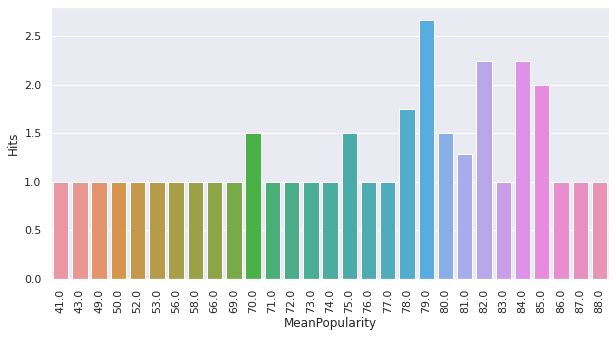

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
data = mean_pop[['MeanPopularity', 'Hits']]
fig = sns.barplot(x = data['MeanPopularity'], y = data['Hits'], ci=None)
plt.xticks(rotation=90)

There is a very slight correlation between mean popularity and # of top 100 hits. This effect would be better illustrated if we was able to obtain a more general artist popularity, rather than the one available in the bounds of this dataset. I believe the mean popularity does not represent true artist popularity as it is skewed by artists with one popular song, aka a 'One Hit Wonder'. 

### How do generes stack up in terms of popularity and # of hits?
We first need to do some aggregation on genres to simplify the grouping. Genres that fall under the base genres listed will be considered the same genre.

In [ ]:
base_genres = ['rap', 'pop', 'rock', 'hip hop', 'r&b', 'dance', 'metal', 'country']
top = raw_songs.iloc[200:, :]
for index, row in top.iterrows():
    for genre in base_genres:
      if genre in row['genre']:
        raw_songs.at[index, 'genre'] = genre
raw_songs['genre'].unique()

array(['dance', 'alternative metal', 'rap', 'pop', 'aesthetic rap',
       'soundtrack', 'metal', 'meme rap', 'melodic metal',
       'lgbtq+ hip hop', 'glam rock', 'christian metal',
       'christian alternative rock', 'la pop', 'emo rap',
       'modern alternative rock', 'k-pop girl group', 'viral rap',
       'art pop', 'viral pop', 'oakland hip hop', 'conscious hip hop',
       'australian rock', 'canadian hip hop', 'hip hop', 'atl hip hop',
       'chicago rap', 'country', 'rock', 'east coast hip hop',
       'alternative r&b', 'indie rap', 'bedroom pop', 'hawaiian hip hop',
       'detroit hip hop', 'modern rock', 'canadian contemporary r&b',
       'melodic rap', 'japanese metal', 'christian hip hop', 'r&b'],
      dtype=object)

In [ ]:
genre_groups = top[['genre', 'popularity']].groupby('genre')
genre_pop = pd.DataFrame(columns=['Genre', 'MeanPopularity', 'Hits'])
#Insert data row by row for each artist
for name, group in genre_groups:
  genre_pop.loc[-1] = [name, group['popularity'].mean(), group.shape[0]]
  genre_pop.index = genre_pop.index + 1  # shifting index
  genre_pop = genre_pop.sort_index() 
genre_pop

,Genre,MeanPopularity,Hits
0,rock,79.444444,9
1,rap,74.952381,21
2,r&b,85.250000,4
3,pop,80.314286,35
4,hip hop,76.833333,6
5,dance,76.920000,25


With our data we could choose to make conclusions based on either mean popularity or # of hits.

In [ ]:
genre_pop.sort_values('MeanPopularity', ascending=False)

,Genre,MeanPopularity,Hits
2,r&b,85.250000,4
3,pop,80.314286,35
0,rock,79.444444,9
5,dance,76.920000,25
4,hip hop,76.833333,6
1,rap,74.952381,21


As discussed in 'Do artists with a higher mean popularity have more top 100 hits?', MeanPopularity is not a very discriptive statistic as it is skewed by single hits. Using this stat would be misleading as it does not represent the genre as a whole as we intend to. 

In [ ]:
genre_pop.sort_values('Hits', ascending=False)

,Genre,MeanPopularity,Hits
3,pop,80.314286,35
5,dance,76.920000,25
1,rap,74.952381,21
0,rock,79.444444,9
4,hip hop,76.833333,6
2,r&b,85.250000,4


Sorting by hits gives us a much better representation of genre popularity. Pop, Dance, and Rap make up 75% of the spotify top 100. When looking at the top three genres, mean popularity becomes a more reliable statistic as it has an actual distribution to describe. The top three genres in terms of hits are now correctly ordered in terms of mean popularity as well. 

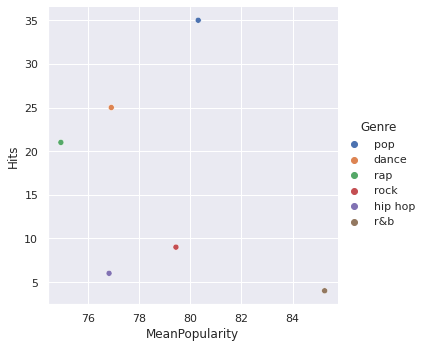

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
new_df = genre_pop.set_index('Genre').sort_values('Hits', ascending=False)
sns.relplot(y = new_df['Hits'], x=  new_df['MeanPopularity'], hue=new_df.index)

However, due to the small sample size and unreliability of the popularity metric, we are unable to see a correlation between mean artitst popularity and nubmer of hits.

### How popular are songs released in each year?

Using a similar method to the previous explorations, we need to isolate the relevant columns and find the mean of each year.

In [ ]:
years = raw_songs[["year", "popularity"]]
sortedYears = years.groupby("year")
yearPop = pd.DataFrame(columns = ["Year", "Mean Popularity", "Amount"])
for year, group in sortedYears:
  yearPop.loc[-1] = [year, group["popularity"].mean(), group.shape[0]]
  yearPop.index += 1
  yearPop = yearPop.sort_index()

yearPop

,Year,Mean Popularity,Amount
0,2021.0,65.148148,27.0
1,2020.0,56.833333,24.0
2,2019.0,72.161290,31.0
3,2018.0,67.866667,45.0
4,2017.0,65.564103,39.0
5,2016.0,69.172414,29.0
6,2015.0,68.758621,29.0
7,2014.0,65.400000,15.0
8,2013.0,53.777778,9.0
9,2012.0,59.083333,12.0


It is interesting to note that the majority of the songs from our dataset are from 2015-2021. Below is a graph of mean popularity of years contained in our dataset. It trends downward due to the popularity of the songs from the 70s, 80s, and 90s. There is only one song in each of the points from that date range, so these songs may be popular due to nostalgia. As such, we considered them as outliers.

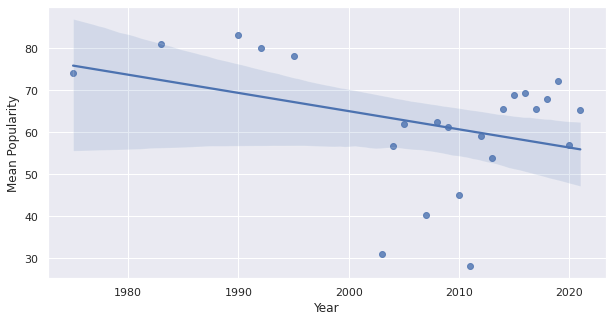

In [ ]:
sns.regplot(x=yearPop['Year'], y=yearPop['Mean Popularity'])


Below, we have a look at the data with the outliers removed. Based on this, the popularity of songs appears to trend upward as they become more recent. The shaded area around the line of best fit shows that the relationship is not strong, but still positive. 

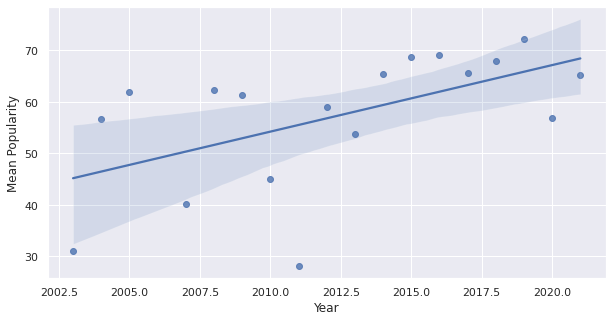

In [ ]:
newPop = yearPop.sort_values("Year", ascending = False).loc[:17, :]
sns.regplot(x=newPop['Year'], y=newPop['Mean Popularity'])